## Rainfall Dataset for Uganda

This experiment will be used to predict 10-day rainfall and examine the relationships between the different features of the dataset.

This dataset contains dekadal rainfall indicators computed from Climate Hazards Group InfraRed Precipitation satellite imagery with insitu Station data (CHIRPS) version 2, aggregated by subnational administrative units.

Included indicators are (for each dekad):

    10 day rainfall [mm] (rfh)
    rainfall 1-month rolling aggregation [mm] (r1h)
    rainfall 3-month rolling aggregation [mm] (r3h)
    rainfall long term average [mm] (rfh_avg)
    rainfall 1-month rolling aggregation long term average [mm] (r1h_avg)
    rainfall 3-month rolling aggregation long term average [mm] (r3h_avg)
    rainfall anomaly [%] (rfq)
    rainfall 1-month anomaly [%] (r1q)
    rainfall 3-month anomaly [%] (r3q)

The administrative units used for aggregation are based on WFP data and contain a Pcode reference attributed to each unit. The number of input pixels used to create the aggregates, is provided in the n_pixelscolumn.

[Reference](https://data.humdata.org/dataset/uga-rainfall-subnational) - Uganda Rainfall dataset (https://data.humdata.org)

## Import necessary modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler

## Import the data

In [2]:
df = pd.read_csv("rainfall_dataset.csv")

## Data Preprocessing

In [3]:
# Removing null columns
null_percentage = df.isnull().mean() * 100
null_cols = null_percentage[null_percentage > 50]
# Check if there are null columns with nulls greater than 50%
if not null_cols.empty:
    # Drop null columns
    df.drop(null_cols.index, axis=1, inplace=True)
    print("Null columns removed:", null_cols.index.tolist())
else:
    print("No null columns with nulls greater than 50%")

# Drop the null rows
df = df.dropna()

# Drop rows where column 'version' has 'prelim' so that we only have final validated rows
df = df[df['version'] != 'prelim']

df.drop(["adm2_id", "ADM2_PCODE", "version"], axis=1, inplace=True)

No null columns with nulls greater than 50%


## Data Preprocessing

In [4]:
# Columns to be scaled
selected_columns = df.columns[1:]  
df_selected = df[selected_columns]

scaler = StandardScaler()
scaler.fit(df[selected_columns])
scaled_columns = scaler.transform(df[selected_columns])
df[selected_columns] = scaled_columns

## Relationship between Dekadal Rainfall and 1-month rolling aggregation, and two month rolling aggregation.

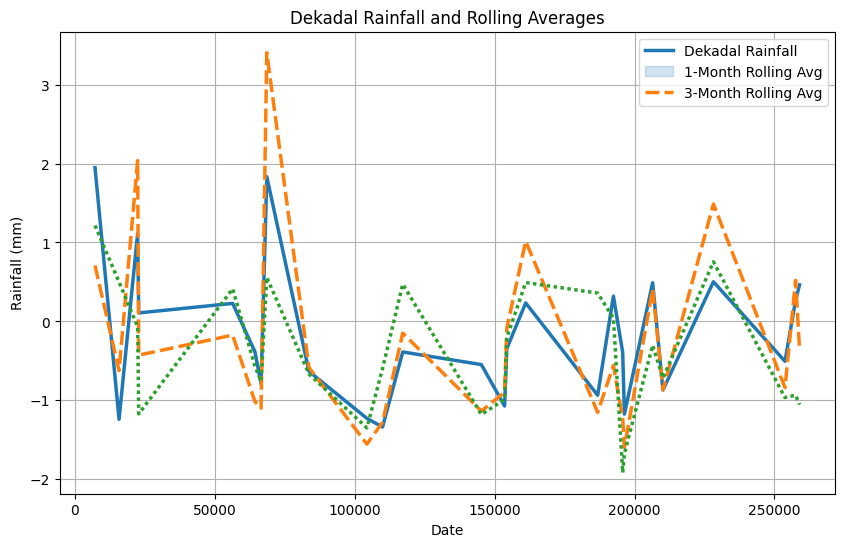

In [5]:
# Sampled data from the dataset
sampled_df = df.sample(frac=0.0001)

plt.figure(figsize=(10, 6))
sns.lineplot(data=sampled_df[['rfh', 'r1h', 'r3h']], linewidth=2.5)
plt.title('Dekadal Rainfall and Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend(['Dekadal Rainfall', '1-Month Rolling Avg', '3-Month Rolling Avg'])
plt.grid(True)
plt.show()

According to this graph, it shows that there is a direct proportionality of dekadal rainfall and the rolling averages, though it is not linear due to the nature of rainfall. The rest of the features could not be used because they are directly derived from 10-day rainfall.

## Using random forest regressor to predict 10 day rainfall.

In [7]:
# Features and target
X = df[['r1h', 'r3h']]
y = df['rfh']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)

